changes in this script:

change the unit of ea by multiplying 10 to hPa from kPa

modify the order of resample and diff for Rin and Rli

do resample and diff for precipitation

## 0)import libraries 

In [74]:
"""
Thesis_PhD_Qianqian Predicted_fluxes_glboal_stripes
date: 24-Feb-2023
author: Qianqian
Contact: q.han@utwente.nl
-------------------------------------
Description: 
"""
# libraries
import os
import joblib
from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.warp import reproject, Resampling
import xarray as xr
import pickle
from PyStemmusScope import variable_conversion as vc
from rasterio.warp import reproject, Resampling
from sklearn.preprocessing import OneHotEncoder
import time
import re
import glob
import rioxarray
import dask.array
from dask.distributed import Client, progress

## 1)settings for Dask

In [75]:
# Set the MALLOC_TRIM_THRESHOLD_ environment variable
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

# Run your Dask script or notebook
...

Ellipsis

In [76]:
client = Client(n_workers=4, threads_per_worker=1)
client

/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33611 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33611/status,
Dashboard: /proxy/33611/status,Workers: 4
Total threads: 4,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35729,Workers: 4
Dashboard: /proxy/33611/status,Total threads: 4
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:40555,Total threads: 1
Dashboard: /proxy/41961/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:39563,


## 2)define working path, load trained model, define functions

In [77]:
workingPath = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/"

In [78]:
# function for loading the trained model
def load_model(path):
    # load trained RF model, better use not parallel model with Dask
    with open(path, 'rb') as f:
        rfLEHmulti = pickle.load(f)
    return rfLEHmulti

In [79]:
# function for getting directory of input data
def get_directories_with_number_and_ending(directory_path, ending):
    directories = []
    if ending:
        pattern = re.compile(r'^\d+.*{}$'.format(re.escape(ending)))  # Match directory names with number at the beginning and specific ending
    else:
        pattern = re.compile(r'^\d+$')  # Match directory names with only numbers

    for entry in os.scandir(directory_path):
        if entry.is_dir():
            directory_name = entry.name
            if pattern.match(directory_name):
                directories.append(directory_name)

    return directories

## 3) read data

In [80]:
### define the path of input data, set the reference file for spatial resample
inputData = workingPath+"1input_data/"
# get all the filefolders named as year
year_list = sorted(get_directories_with_number_and_ending(workingPath+"1input_data/", "global"))
# the input data from year[0] to year[..], based on the process id in sbatch script
year = year_list[14]
print(year)

2014global


In [81]:
import geopandas as gpd
from shapely.geometry import box

shapefile_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/Emulator/input_data/EuropeBoundary.shp"
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds
bbox

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


array([-31.28903052,  34.93055094,  68.93136141,  81.85192337])

In [82]:
lat1 = 40
lat2 = 45
lon1 = 2
lon2 = 7

In [83]:
## 0) read era5land data
all1 = xr.open_zarr(inputData+year+"/era5land/era5land2014_10km1030.zarr") 

In [84]:
all1.chunks

Frozen({'time': (500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 260), 'latitude': (250, 219), 'longitude': (250, 250, 250, 250, 2)})

In [85]:
all1

<xarray.Dataset>
Dimensions:    (time: 8760, latitude: 469, longitude: 1002)
Coordinates:
  * latitude   (latitude) float32 81.8 81.7 81.6 81.5 ... 35.3 35.2 35.1 35.0
  * longitude  (longitude) float32 -31.2 -31.1 -31.0 -30.9 ... 68.7 68.8 68.9
  * time       (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(500, 250, 250), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(500, 250, 250), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(500, 250, 250), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(500, 250, 250), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(500, 250, 250), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(500, 250, 250), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(500, 250, 250), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(500, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 03:39:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [86]:
chunksizeLat = 110
chunksizeLon = 110

In [87]:

all1 = all1.chunk({"time":125, "latitude":chunksizeLat, "longitude":chunksizeLon}) #
all1 = all1.sel(
    latitude=slice(lat2, lat1),  
    longitude=slice(lon1, lon2)  
)

In [88]:
all1.chunks

Frozen({'time': (125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 10), 'latitude': (51,), 'longitude': (51,)})

In [89]:
# all_resample = all1.resample(time="1800S").interpolate('linear')
# all_resample = all_resample.isel(time=slice(0,17000))


In [90]:
all1

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.Dataset>
Dimensions:    (time: 8760, latitude: 51, longitude: 51)
Coordinates:
  * latitude   (latitude) float32 45.0 44.9 44.8 44.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * time       (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 03:39:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [91]:
# all1 = all1.persist()

In [92]:
all1.chunks

Frozen({'time': (125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 10), 'latitude': (51,), 'longitude': (51,)})

In [93]:
# %%time
# # calculate the Rin and Rli difference for every hour
Rin = all1['ssrd'].diff("time")/3600  
Rin[0::24] = all1['ssrd'][1::24]/3600 # assign the original values in t01
Rli = all1['strd'].diff("time")/3600  
Rli[0::24] = all1['strd'][1::24]/3600


In [94]:
%%time
preci = all1['tp'].diff("time")  #xr.concat([all1['ssrd'].isel(time=0),all1['ssrd']], dim="time")
preci[0::24] = all1['tp'][1::24] # assign the original values in t01

CPU times: user 1.33 s, sys: 8.95 ms, total: 1.34 s
Wall time: 1.34 s


In [95]:
Rin.chunks

((124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  124,
  1,
  9),
 (51,),
 (51,))

In [96]:
all1.nbytes/2**30

0.6791044101119041

In [97]:
### 1) read LAI data
lai = xr.open_dataset(inputData+"/2014global/lai/LAI_europe2014_10km.nc",chunks={"latitude":chunksizeLat, "longitude":chunksizeLon})['LAI']

In [98]:
lai = lai.sel(
    latitude=all1.latitude,  
    longitude=all1.longitude,
    method='nearest', tolerance=0.01
)
# lai = lai.chunk({"latitude":chunksizeLat, "longitude":chunksizeLon}) #

In [99]:
lai = lai.assign_coords(longitude=all1.longitude, latitude=all1.latitude)

In [100]:
lai.chunks

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


((36,), (51,), (51,))

In [101]:
lai = lai.resample(time="3600S").interpolate('linear')

In [102]:
lai.chunks

((8521,), (51,), (51,))

In [103]:
### 2) read canopy height data
hc_path = inputData+year+'/canopy_height/canopy_height_11kmEurope20230921_10km.nc'
hc = xr.open_dataset(hc_path,chunks={"y":chunksizeLat, "x":chunksizeLon}).rename({'x':'longitude','y':'latitude'})['__xarray_dataarray_variable__']

In [104]:
hc = hc.sel(
    latitude=all1.latitude,  
    longitude=all1.longitude,
    method='nearest', tolerance=0.01
)
# hc = hc.chunk({"latitude":chunksizeLat, "longitude":chunksizeLon}) #
hc = hc.assign_coords(longitude=all1.longitude, latitude=all1.latitude)
hc

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, latitude: 51,
                                                   longitude: 51)>
dask.array<getitem, shape=(1, 51, 51), dtype=float32, chunksize=(1, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude   (latitude) float32 45.0 44.9 44.8 44.7 ... 40.3 40.2 40.1 40.0
  * band       (band) int64 1
Attributes:
    scales:         1.0
    offsets:        0.0
    descriptions:   b1
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

In [105]:
hc.chunks

((1,), (51,), (51,))

In [106]:
### 3) read CO2 data
## resampled CO2
ds_co2_10km = xr.open_dataset(inputData+year+"/co2/CAMS_CO2_2014_10km.nc",chunks={"latitude":chunksizeLat, "longitude":chunksizeLon})['co2']
ds_co2_10km = ds_co2_10km.sel(
    latitude=all1.latitude,  
    longitude=all1.longitude,
    method='nearest', tolerance=0.01
)
# ds_co2_10km = ds_co2_10km.chunk({"latitude":chunksizeLat, "longitude":chunksizeLon}) #
ds_co2_10km = ds_co2_10km.assign_coords(longitude=all1.longitude, latitude=all1.latitude)

In [107]:
# ds_co2_10km=ds_co2_10km.assign_coords({'time':('time',ds_co2_10km.time.values + np.timedelta64(150,'m'),ds_co2_10km.time.attrs)})

In [108]:
ds_co2_10km

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'co2' (time: 2920, latitude: 51, longitude: 51)>
dask.array<getitem, shape=(2920, 51, 51), dtype=float32, chunksize=(2920, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude   (latitude) float32 45.0 44.9 44.8 44.7 ... 40.3 40.2 40.1 40.0
  * time       (time) datetime64[ns] 2014-01-01T00:30:00 ... 2014-12-31T21:30:00
Attributes:
    grid_mapping:  spatial_ref

In [109]:
ds_co2_10km = ds_co2_10km.resample(time="3600S").interpolate('linear')

In [110]:
ds_co2_10km.chunks

((8758,), (51,), (51,))

In [111]:
### 4) read the resampled SSM data
## netcdf file works well
path_SSM = glob.glob(inputData+year+"/ssm/SM2014Europe11kmEurope20231030_10km.nc")[0]
ds_SSM = xr.open_dataset(path_SSM,chunks={"latitude":chunksizeLat, "longitude":chunksizeLon})['__xarray_dataarray_variable__'].rename('SSM')
# ds_SSM = ds_SSM.sortby(["longitude", "latitude"])
ds_SSM = ds_SSM.sel(
    latitude=all1.latitude,  
    longitude=all1.longitude,
    method='nearest', tolerance=0.01
)
# ds_SSM = ds_SSM.chunk({"latitude":chunksizeLat, "longitude":chunksizeLon}) #
ds_SSM = ds_SSM.assign_coords(longitude=all1.longitude, latitude=all1.latitude)
SSM = ds_SSM.resample(time="3600S").interpolate('linear')/1000 

In [112]:
SSM.chunks

((8737,), (51,), (51,))

In [113]:
### 5) read Vcmax data
ds_Vcmo = xr.open_dataset(inputData+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc",chunks={"y":chunksizeLat, "x":chunksizeLon}).rename({'x':'longitude','y':'latitude'})['__xarray_dataarray_variable__']

In [114]:
ds_Vcmo

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, latitude: 1801,
                                                   longitude: 3600)>
dask.array<open_dataset-3d5c93dc4ef38b0d46164c12254fb901__xarray_dataarray_variable__, shape=(1, 1801, 3600), dtype=float32, chunksize=(1, 110, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * band       (band) int64 1
Attributes:
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

In [115]:
ds_Vcmo = ds_Vcmo.sel(
    latitude=all1.latitude,  
    longitude=all1.longitude,
    method='nearest', tolerance=0.01
)
# ds_Vcmo = ds_Vcmo.chunk({"latitude":chunksizeLat, "longitude":chunksizeLon}) #
ds_Vcmo = ds_Vcmo.assign_coords(longitude=all1.longitude, latitude=all1.latitude)

In [116]:
ds_Vcmo.chunks 

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


((1,), (51,), (51,))

## why the chunks of ds_Vcmo and landcover after sel function is different from the above variables? because TROPOMI_Vmax_Tg_mean10km_global.nc is global? maybe we should load the data and select the roi, and then chunks?
but we will do the following later, so maybe it is okay like this, only ds_Vcmo and landcover has this problems?

hc=hc.chunk({"latitude":51, "longitude":51}).squeeze()

ds_Vcmo = ds_Vcmo.chunk({"latitude":51, "longitude":51}).squeeze()

landcover = landcover.chunk({"latitude":51, "longitude":51}).squeeze()

In [117]:
### 6) read IGBP data
# read lan
path_landcover = inputData+year+"/igbp/landcover10km_global.nc"
# landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto").rename({'x':'longitude','y':'latitude'})
landcover = xr.open_dataset(path_landcover, chunks={"y":chunksizeLat, "x":chunksizeLon}).rename({'x':'longitude','y':'latitude'})['lccs_class']
landcover = landcover.sel(
    latitude=all1.latitude,  
    longitude=all1.longitude,
    method='nearest', tolerance=0.01
)
# landcover = landcover.chunk({"latitude":chunksizeLat, "longitude":chunksizeLon}) #
landcover = landcover.assign_coords(longitude=all1.longitude, latitude=all1.latitude)

In [118]:
# read IGBP unique values
data = pd.read_csv(inputData+'IGBP11unique.csv')['0'].unique()
# read the table for converting landcover to IGBP
IGBP_table = pd.read_csv(inputData+year+"/igbp/lccs_to_igbp_table.csv")

In [119]:
def landcover_to_igbp(landcover, IGBP_table, data):
    IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)(landcover.values)
    IGBP_all = pd.DataFrame(columns=['IGBP_veg_long1', 'IGBP_veg_long2', 'IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5',
                              'IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8','IGBP_veg_long9',
                             'IGBP_veg_long10','IGBP_veg_long11'])
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(categories=[data]*1,sparse=False,
                           handle_unknown = "ignore")
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[0]*IGBP.shape[1],1))
    # assign 23-D IGBP into 23 columns
    for i in range(1,12,1):
        IGBP_all['IGBP_veg_long'+str(i)] = aa[:,i-1]
    return IGBP_all

## 4) chunk all the input variables

In [120]:
ds_era5land = all1

ds_ss = xr.Dataset()

ds_ss["Rin"] = Rin#.isel(time=slice(0,17000))
ds_ss["Rli"] = Rli#.isel(time=slice(0,17000))
ds_ss["p"] = all1["sp"]/100  # Pa -> hPa
ds_ss["Ta"] = all1["t2m"]- 273.15  # K -> degC
ds_ss["ea"] = vc.calculate_es(all1["d2m"] - 273.15)*10
ds_ss["u"] = (all1["u10"] ** 2 + all1["v10"] ** 2) ** 0.5
ds_ss["Precip_msr"] = preci.isel(time=slice(0,17000))*1000   # mm
ds_ss['LAI'] = lai
ds_ss['CO2'] = ds_co2_10km
ds_ss['SSM'] = SSM


In [121]:
ds_ss['LAI'].chunks

((8759,), (51,), (51,))

In [122]:
ds_ss.nbytes/2**30

0.8487671986222267

In [123]:
ds_ss = ds_ss.persist()

## 5) predict fluxes with map_blocks

In [124]:
ds_ss = ds_ss.to_array()

In [125]:
ds_ss = ds_ss.chunk({"time":125, "variable":10})

In [126]:
ds_ss.chunks

((10,),
 (125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  125,
  9),
 (51,),
 (51,))

In [127]:
# hc=hc.chunk({"latitude":51, "longitude":51}).squeeze()
hc = hc.squeeze()
ds_Vcmo = ds_Vcmo.chunk({"latitude":ds_ss.chunks[2], "longitude":ds_ss.chunks[3]}).squeeze()
landcover = landcover.chunk({"latitude":ds_ss.chunks[2], "longitude":ds_ss.chunks[3]}).squeeze()

In [128]:
chunks = [ds_ss.chunksizes[v] for v in ['time', 'latitude', 'longitude']]
chunks.append((7,))

In [129]:
estimated_LEH = xr.DataArray(
    name = 'LEH',
    data=dask.array.zeros((len(ds_ss.time), len(ds_ss.latitude), len(ds_ss.longitude),7), chunks=chunks),
    dims=("time", "latitude", "longitude","variable_out"),
    coords={
        "variable_out":range(7), 
        "time":ds_ss.time, 
        "latitude":ds_ss.latitude,
        "longitude":ds_ss.longitude
    }
)

In [130]:
estimated_LEH

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'LEH' (time: 8759, latitude: 51, longitude: 51,
                         variable_out: 7)>
dask.array<zeros_like, shape=(8759, 51, 51, 7), dtype=float64, chunksize=(125, 51, 51, 7), chunktype=numpy.ndarray>
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2014-01-01T01:00:00 ... 2014-12-31T23...
  * latitude      (latitude) float32 45.0 44.9 44.8 44.7 ... 40.3 40.2 40.1 40.0
  * longitude     (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.7 6.8 6.9 7.0

In [131]:
def predictFlux(ds_ss, hc, ds_Vcmo, landcover, IGBP_table, training_testing_append, path_model):
    hc_line = np.tile(hc.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size) #如果和动态变量一样放进ds_ss里显示为一些离散的点，不知道为什么，所以静态变量放在时间循环外面
    Vcmo_line = np.tile(ds_Vcmo.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP_all = landcover_to_igbp(landcover, IGBP_table, training_testing_append)
    IGBP1 = np.tile(IGBP_all.iloc[:,0].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP2 = np.tile(IGBP_all.iloc[:,1].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP3 = np.tile(IGBP_all.iloc[:,2].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP4 = np.tile(IGBP_all.iloc[:,3].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP5 = np.tile(IGBP_all.iloc[:,4].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP6 = np.tile(IGBP_all.iloc[:,5].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP7 = np.tile(IGBP_all.iloc[:,6].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP8 = np.tile(IGBP_all.iloc[:,7].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP9 = np.tile(IGBP_all.iloc[:,8].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP10 = np.tile(IGBP_all.iloc[:,9].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP11 = np.tile(IGBP_all.iloc[:,10].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    
    
    Rin_line = ds_ss[0,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Rli_line = ds_ss[1,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    p_line = ds_ss[2,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Ta_line = ds_ss[3,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    ea_line = ds_ss[4,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    u_line = ds_ss[5,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Precip_msr_line = ds_ss[6,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    LAI_line = ds_ss[7,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    CO2_line = ds_ss[8,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    SSM_line = ds_ss[9,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)

    features_arr = np.concatenate((Rin_line, Rli_line, p_line, Ta_line,ea_line, u_line, CO2_line,LAI_line,
                                    Vcmo_line, hc_line, Precip_msr_line,SSM_line,
                                   IGBP1, IGBP2, IGBP3,IGBP4,IGBP5,IGBP6,IGBP7,IGBP8,IGBP9,IGBP10,IGBP11))
    features_arr = features_arr.transpose()
    print(features_arr.shape)
    # Nan value.
    df_features = pd.DataFrame(data=features_arr)
    df_features_drop_nan = df_features.dropna()
    invalid_index = sorted(set(df_features.index.to_list()) - set(df_features_drop_nan.index.to_list()))

    # # Convert the nan value as 0 for the calculation
    where_are_NaNs = np.isnan(features_arr)
    features_arr[where_are_NaNs] = 0
    
    model = load_model(path_model)
    
    # model = path_model
    features_arr1 = pd.DataFrame(data=features_arr)
    features_arr1.columns = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2','LAI','Vcmo','hc','Precip_msr','SSM',
            'IGBP_veg_long1','IGBP_veg_long2','IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5','IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8',
            'IGBP_veg_long9','IGBP_veg_long10','IGBP_veg_long11']
    estimated_LEH = model.predict(features_arr1)
    estimated_LEH[invalid_index] = np.nan
    LEH_map = estimated_LEH.reshape(ds_ss.time.size, ds_ss.latitude.size, ds_ss.longitude.size,7)
    
    return xr.DataArray(
        name = 'LEH',
        data=LEH_map,
        dims=("time", "latitude", "longitude","variable_out"),
        coords={
            "variable_out":range(7), 
            "time":ds_ss.time, 
            "latitude":ds_ss.latitude,
            "longitude":ds_ss.longitude
        }
    )
result = xr.map_blocks(
    predictFlux,
    ds_ss,
    args=[hc, ds_Vcmo, landcover],
    kwargs={"IGBP_table":IGBP_table, "training_testing_append":data, "path_model":workingPath+'3RF_train/hourly_multi7_depth20_min1219.pkl'},
    template=estimated_LEH,
)

In [132]:
result = result.chunk({"latitude":200, "longitude":200})

In [133]:
# result = result.assign_coords(variable_out=['LEtot','Htot','Rntot','Gtot', 'Actot','SIF685', 'SIF740'])
# result_ds = result.to_dataset(dim="variable_out")

In [134]:
result = result.assign_coords(variable_out=['LEtot','Htot','Rntot', 'RSSM', 'SIF685', 'SIF740', 'Actot'])
result_ds = result.to_dataset(dim="variable_out")

In [135]:
result_ds.chunks

Frozen({'time': (125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 9), 'latitude': (51,), 'longitude': (51,)})

In [ ]:
%%time
result_ds.to_zarr("/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_testQQ1.zarr", mode='w')

In [70]:
result = result.persist()

In [ ]:
result[2000,:,:,1].plot()

In [ ]:
start_time = time.time()  # Record the start time
result1 = result.compute()
end_time = time.time()  # Record the end time
total_running_time = end_time - start_time
print("Total Running Time:", total_running_time)

In [ ]:
result1

In [86]:
all1

<xarray.Dataset>
Dimensions:    (time: 8760, latitude: 21, longitude: 11)
Coordinates:
  * latitude   (latitude) float32 47.0 46.9 46.8 46.7 ... 45.3 45.2 45.1 45.0
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.0
  * time       (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(500, 21, 11), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(500, 21, 11), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(500, 21, 11), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(500, 21, 11), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(500, 21, 11), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(500, 21, 11), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(500, 21, 11), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(500, 21, 11), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 03:39:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
result1[:,:,:,1].mean()

In [ ]:
np.nanmean(np.nanmean(result1[:,:,:,1],axis=(1,2)))

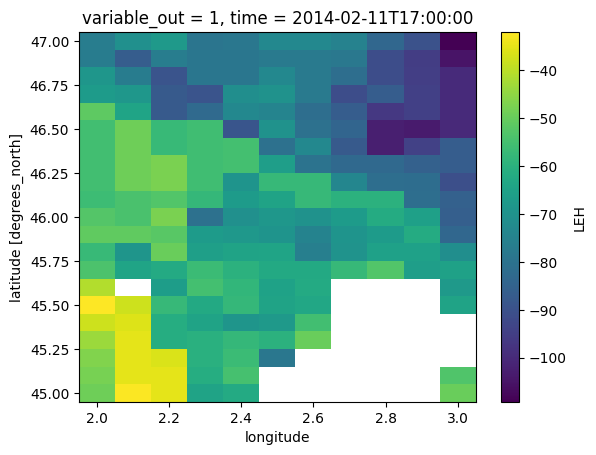

In [88]:
result1[2000,:,:,1].plot()

## export the result

In [137]:
QQ = xr.open_zarr("/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_testQQ1.zarr")

In [138]:
original = xr.open_zarr("/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_30degrees_1219.zarr")

In [157]:
fran = xr.open_zarr("/gpfs/work2/0/ttse0619/qianqian/5output_data/2014fluxes_test.zarr")

In [149]:
QQ

<xarray.Dataset>
Dimensions:    (time: 8759, latitude: 51, longitude: 51)
Coordinates:
  * latitude   (latitude) float32 45.0 44.9 44.8 44.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * time       (time) datetime64[ns] 2014-01-01T01:00:00 ... 2014-12-31T23:00:00
Data variables:
    Actot      (time, latitude, longitude) float64 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    Htot       (time, latitude, longitude) float64 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    LEtot      (time, latitude, longitude) float64 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    RSSM       (time, latitude, longitude) float64 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    Rntot      (time, latitude, longitude) float64 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    SIF685     (time, latitude, longitude) float64 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>
    SIF740     (time, latitude, longitude) float64 dask.array<chunksize=(125, 51, 51), meta=np.ndarray>

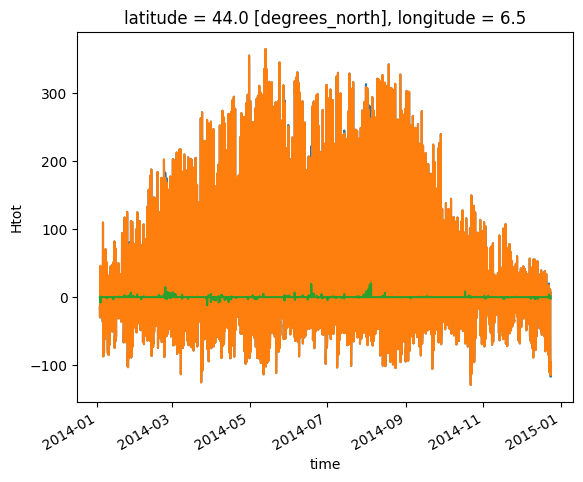

In [160]:

# original.sel(latitude=44,longitude=6.5)['Htot'][100:2000].plot()
QQ['Htot'][:,10,45].plot()
fran['Htot'][:,10,45].plot()
(QQ['Htot'][:,10,45] - fran['Htot'][:,10,45]).plot()
# (QQ['Htot'][100:2000,10,45] - original.sel(latitude=44,longitude=6.5)['Htot'][100:2000]).plot()

<xarray.Dataset>
Dimensions:    (time: 8759)
Coordinates:
    latitude   float32 44.0
    longitude  float32 6.5
  * time       (time) datetime64[ns] 2014-01-01T01:00:00 ... 2014-12-31T23:00:00
Data variables:
    Actot      (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    Gtot       (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    Htot       (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    LEtot      (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    Rntot      (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    SIF685     (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    SIF740     (time) float64 dask.array<chunksize=(500,), meta=np.ndarray>